<a href="https://colab.research.google.com/github/longna88/ga-shift-prediction/blob/main/ga_shift_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import umap.umap_ as umap
from datetime import datetime
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_validate, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import make_scorer

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# suppress
import os
os.environ["PYTHONWARNINGS"] = "ignore"
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

separator = '___________________________'

In [ ]:
def mean_error(y_true, y_pred):
    return np.mean(y_true - y_pred)

mean_error_scorer = make_scorer(mean_error, greater_is_better=False)
mean_absolute_error_scorer = make_scorer(mean_absolute_error, greater_is_better=True)
mean_squared_error_scorer = make_scorer(mean_squared_error, greater_is_better=True)
r2_scorer = make_scorer(r2_score)

# nested cross validation
def get_best_params_reg(pipeline, params, X, y):

    grid = GridSearchCV(pipeline, param_grid=params, cv=KFold(n_splits=5, shuffle=True, random_state=7),
                        scoring='neg_mean_squared_error', n_jobs=-1)

    cv = KFold(n_splits=5, shuffle=True, random_state=7)
    scoring = {
        'mean_error': mean_error_scorer,
        'mean_absolute_error': mean_absolute_error_scorer,
        'mean_squared_error': mean_squared_error_scorer,
        'r2': r2_scorer
    }

    scores = cross_validate(grid, X, y, scoring=scoring, cv=cv, n_jobs=-1)

    grid.fit(X, y)
    best_params = grid.best_params_

    return scores, best_params

def print_scores(scores):
    print(f'Mean error: {np.mean(scores["test_mean_error"])}')
    print(f'Mean absolute error: {np.mean(scores["test_mean_absolute_error"])}')
    print(f'Mean squared error: {np.mean(scores["test_mean_squared_error"])}')
    print(f'R2: {np.mean(scores["test_r2"])}')


def plot_stats(df, groups, results_dir):
    '''
    Plot correlation matrix.
    Plot correlation for each feature with target.
    Plot distribution for each feature per group.
    '''

    correlation_matrix = df.corr()
    plt.figure(figsize=(15, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Pearson Correlation Heatmap')
    plt.savefig(f'{results_dir}/corr_heatmap.png')
    plt.show()

    correlation = df.corr()[['target']].drop('target')
    plt.figure(figsize=(5, len(correlation) * 0.5 + 3))
    sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title(f'Pearson Correlation with Target feature')
    plt.savefig(f'{results_dir}/corr_target.png')
    plt.show()

    # Boxplots and T-test only for numeric features (skip binary)
    features = [col for col in df.columns if df[col].nunique() > 2]

    rows, cols = 2, 3
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten()

    for i, feature in enumerate(features):
        sns.boxplot(x='group', y=feature, data=df, ax=axes[i])
        asa_group = df[df['group'] == groups[0]][feature]
        non_asa_group = df[df['group'] == groups[1]][feature]
        t_stat, p_value = stats.ttest_ind(asa_group, non_asa_group, equal_var=False)
        axes[i].set_title(f'{feature} (p={p_value:.3f})')
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['left'].set_visible(False)
        axes[i].spines['bottom'].set_visible(False)


    # Hide unused subplots if features are less than available grid slots
    for j in range(i + 1, rows * cols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig(f'{results_dir}/boxplots.png')
    plt.show()

def calculate_shift(y_true, y_pred, results_dir='./results', title='', plot_title=''):
    """
    Perform paired t-test, compute 95% confidence interval.
    Scatter plot for comparison of true and predicted values.
    Calculate mean shift in gestation age and visualize on bar chart.
    Visualize shift in predictions: bar plot and kde.

    Parameters:
        y_true (array-like): Observed gestational age
        y_pred (array-like): Predicted gestational age
        results_dir (string): Name of directory where results will be saved
        title (string): Title prefix for figures
        plot_title (string): Name on plot specifying group represented

    """

    print('Metrics:')
    print(f'Mean error: {mean_error(y_true, y_pred)}')
    print(f'Mean absolute error: {mean_absolute_error(y_true, y_pred)}')
    print(f'Mean squared error: {mean_squared_error(y_true, y_pred)}')
    print(separator)

    # Perform paired t-test
    t_stat, p_value = stats.ttest_rel(y_true, y_pred)

    # Compute 95% Confidence Interval
    diff = y_true - y_pred
    mean_diff = np.mean(diff)
    std_err = stats.sem(diff)
    ci95 = stats.t.interval(0.95, df=len(diff)-1, loc=mean_diff, scale=std_err)

    print('Statistics:')
    print(f"T-test: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")
    print(f"95% Confidence Interval: {ci95}")
    print(separator)


    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
    plt.xlabel("Observed gestational age")
    plt.ylabel("Predicted gestational age")
    plt.title(plot_title)
    plt.box(False)
    plt.savefig(f'{results_dir}/{title}_predictions_scatter.png')
    plt.show()


    # expectation: red line shifted from 0
    mean_shift = np.mean(diff)
    median_shift = np.median(diff)

    plt.figure(figsize=(6, 4))
    sns.histplot(diff, bins=30, kde=True)
    plt.axvline(mean_shift, color='red', linestyle='--', label=f"Mean shift: {mean_shift:.2f}")
    plt.axvline(median_shift, color='black', linestyle='--', label=f"Median shift: {median_shift:.2f}")
    plt.xlabel("Shift")
    plt.ylabel("Frequency")
    plt.title(f"Residual distribution of {plot_title}")
    plt.legend()
    plt.box(False)
    plt.savefig(f'{results_dir}/{title}_shift_bar.png')
    plt.show()


    # X-axis positions
    n_samples = len(y_true)
    x = np.arange(n_samples) * 1.5
    width = 0.4  # Bar width

    # Visualize predictions difference on bar plot
    plt.figure(figsize=(16, 6))
    plt.bar(x - width/2, y_true, width, label='Observed gestational age', color='black')
    plt.bar(x + width/2, y_pred, width, label='Predicted gestational age', color='red')

    # Labels and title
    plt.xlabel('Sample Index')
    plt.ylabel('Gestational age (week)')
    plt.title(f'Comparison of True and Predicted Values on {plot_title}')
    plt.xticks(ticks=x, labels=[str(i) for i in range(n_samples)], rotation=90)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)

    plt.tight_layout()
    plt.savefig(f'{results_dir}/{title}_predictions_bar.png')
    plt.show()


    # Visualize distribution difference between true and predicted values
    mean1 = np.mean(y_true)
    mean2 = np.mean(y_pred)
    mean_diff = mean2 - mean1

    plt.figure(figsize=(8, 5))
    sns.kdeplot(y_true, fill=True, color="black", alpha=0.5, label="Observed gestational age")
    sns.kdeplot(y_pred, fill=True, color="red", alpha=0.5, label="Predicted gestational age")

    # Add arrow connecting means
    y_mid = 0.5 * max(plt.ylim())
    plt.annotate(
        "",
        xy=(mean2, y_mid), xytext=(mean1, y_mid),
        arrowprops=dict(arrowstyle="->", lw=2, color="purple")
    )
    plt.text((mean1 + mean2) / 2, y_mid + 0.02 * max(plt.ylim()),
             f"{mean_diff:.2f}", ha="center", fontsize=12, color="black")

    plt.title(f"Distribution difference of {plot_title}")
    plt.xlabel("Gestational age (week)")
    plt.ylabel("Density")
    plt.legend(loc='upper left')
    plt.box(False)
    plt.savefig(f'{results_dir}/{title}_shift_kde.png')
    plt.show()

In [ ]:
df = pd.read_excel('/content/PE shift_Long_short.xlsx')
df.columns

Index(['No', 'High-risk', 'Intervention_code', 'Studyphase_code',
       'Aspirin_Code', 'AdjOdds_PE_LT37_Centre', 'Gaweek',
       'intervaltreatmenttodel', 'GA at PE diagnosis', 'onset PE week',
       'interval_onsettodel', 'MAge_EDD', 'HEIGHT', 'WEIGHT', 'ETHNICITY_code',
       'CHRONIC_HT', 'SLE/APS', 'DMTYPE1', 'DMTYPE2', 'FAMHXPE', 'SMOKER',
       'CONCEPTION_code', 'Prev_Preg_code', 'Preg_Interval', 'MAP_MOM_CENTRE',
       'UTAPI_MOM_Centre', 'PLGF_MOM_Centre', 'Gender', 'BW', 'outcomes',
       'babypercentile'],
      dtype='object')

In [ ]:
# FIX: include more features??
columns_of_interest = [
    'target',
    'group',
    'AdjOdds_PE_LT37_Centre', 'MAge_EDD', 'HEIGHT', 'WEIGHT', 'ETHNICITY_code','FAMHXPE', 'SMOKER',
       'CONCEPTION_code', 'Prev_Preg_code', 'Preg_Interval',
    'CHRONIC_HT',
    'MAP_MOM_CENTRE',
    'UTAPI_MOM_Centre',
    'PLGF_MOM_Centre',
    'SLE/APS',
    'DMTYPE1',
    'DMTYPE2',
]

# Model and parameters grid
model = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', RandomForestRegressor(random_state=47))
    ])

params = {
        'regressor__n_estimators': [100, 200],
        'regressor__max_depth': [3, 5, 10],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2, 4]
    }

In [ ]:
# Quyet: Create folder to store output
os.makedirs('/content/results_gaweek_intervention_code', exist_ok=True)
os.makedirs('/content/results_gaweek_studyphase_code', exist_ok=True)
os.makedirs('/content/results_onset_pe_intervention_code', exist_ok=True)

# copied from Untitled4 https://colab.research.google.com/drive/1efm8tE-UIFRXOIhyOUgDI81hNJrK1zkw?authuser=1#scrollTo=lTgpE42JO_mS
os.makedirs('/content/results_onset_pe_studyphase_code', exist_ok=True)

In [ ]:
# Groups: Intervention_code 0 or 1, target: Gaweek
df_int_gaw = df.dropna(subset='Intervention_code', axis=0).copy()
df_int_gaw.rename(columns={'Intervention_code' : 'group', 'Gaweek' : 'target'}, inplace=True)

# Groups: Studyphase_code 2 or 3, target: Gaweek
df_stud_gaw = df.dropna(subset='Studyphase_code', axis=0).copy()
df_stud_gaw = df_stud_gaw[df_stud_gaw['Studyphase_code'] != 1]
df_stud_gaw.rename(columns={'Studyphase_code' : 'group', 'Gaweek' : 'target'}, inplace=True)

# Groups: Intervention_code 0 or 1, target: onset PE week
df_int_ons = df.dropna(subset='Intervention_code', axis=0).copy()
df_int_ons.rename(columns={'Intervention_code' : 'group', 'onset PE week' : 'target'}, inplace=True)
df_int_ons = df_int_ons.dropna(subset='target', axis=0)

# copied from Untitled4
# rename df_int_ons to df_stu_ons
# Groups: studyphase_code 2 or 3, target: onset PE week
df_stu_ons = df.dropna(subset='Studyphase_code', axis=0).copy()
df_stu_ons.rename(columns={'Studyphase_code' : 'group', 'onset PE week' : 'target'}, inplace=True)
df_stu_ons = df_stu_ons.dropna(subset='target', axis=0)


configurations = [
    {
        'title' : 'INTERVENTION CODE, GAWEEK',
        'df' : df_int_gaw,
        'groups' : [1, 0], # [train group, test group]
        'results_dir' : './results_gaweek_intervention_code', # change from .. to .
        'plot_title' : 'Gestational age at delivery on HR without aspirin in the intervention phase'
    },
    {
        'title' : 'STUDYPHASE CODE, GAWEEK',
        'df' : df_stud_gaw,
        'groups' : [3, 2], # [train group, test group]
        'results_dir' : './results_gaweek_studyphase_code', # change from .. to .
        'plot_title' : 'Gestational age at delivery in non-intervention phase'
    },
    {
        'title' : 'INTERVENTION CODE, ONSET PE WEEK',
        'df' : df_int_ons,
        'groups' : [1, 0], # [train group, test group]
        'results_dir' : './results_onset_pe_intervention_code', # change from .. to .
        'plot_title' : 'Gestational age at onset on HR without aspirin in the intervention phase'
    },
    # copied from Untitled4
    {
        'title' : 'STUDYPHASE CODE, ONSET PE WEEK',
        'df' : df_stu_ons,
        'groups' : [3, 2], # [train group, test group]
        'results_dir' : './results_onset_pe_studyphase_code', # change from .. to .
        'plot_title' : 'Onset PE week for studyphase code 0'
    }
]

In [ ]:
def compute_mean_and_confidence_interval(y_test, y_pred):
    mean_test = np.mean(y_test)
    confidence_interval_test = stats.t.interval(
        0.95, len(y_test) - 1, loc=np.mean(y_test), scale=stats.sem(y_test)
    )

    # Calculate mean and confidence interval for y_pred
    mean_pred = np.mean(y_pred)
    confidence_interval_pred = stats.t.interval(
        0.95, len(y_pred) - 1, loc=np.mean(y_pred), scale=stats.sem(y_pred)
    )

    print(f"True Mean: {mean_test:.2f}")
    print(f"True 95% CI: {confidence_interval_test[0]:.2f} - {confidence_interval_test[1]:.2f}")
    print(f"Pred Mean: {mean_pred:.2f}")
    print(f"Pred 95% CI: {confidence_interval_pred[0]:.2f} - {confidence_interval_pred[1]:.2f}")

___________________________ 
 

INTERVENTION CODE, GAWEEK


,target,group,AdjOdds_PE_LT37_Centre,MAge_EDD,HEIGHT,WEIGHT,ETHNICITY_code,FAMHXPE,SMOKER,CONCEPTION_code,Prev_Preg_code,Preg_Interval,CHRONIC_HT,MAP_MOM_CENTRE,UTAPI_MOM_Centre,PLGF_MOM_Centre,SLE/APS,DMTYPE1,DMTYPE2
8,33,1.0,72,19.9807,150.0,44.0,1,0,0,1,1,NaN,0,1.0423,1.1713,0.5462,0,0,0
12,38,1.0,61,32.5120,162.0,68.0,1,0,0,1,1,NaN,0,1.0017,1.7310,0.6739,0,0,0
13,41,1.0,37,26.4421,165.0,61.0,1,0,0,1,1,NaN,0,1.0480,1.3636,0.4203,0,0,0
14,35,1.0,82,30.6419,161.0,52.0,1,0,0,1,1,NaN,0,1.2227,0.6335,0.5187,0,0,0
15,36,1.0,7,25.2649,157.0,62.0,1,0,0,1,1,NaN,0,1.4362,0.9253,0.5744,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851,38,0.0,5,31.2389,156.0,88.0,1,0,0,1,1,NaN,1,1.1765,1.6995,1.0392,0,0,0
852,37,0.0,50,32.9637,158.0,71.0,1,0,0,3,1,NaN,0,1.1313,1.1157,0.9588,0,0,0
853,36,0.0,26,35.4825,140.0,50.0,1,0,0,1,2,5.23,1,1.1454,0.7024,1.4084,0,0,0
854,37,0.0,56,40.2162,159.0,87.0,1,0,0,1,1,NaN,0,1.0623,1.3515,1.0526,0,0,0


Best hyperparameters: {'regressor__max_depth': 3, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
Model Evaluation:
Mean error: 0.014603412400788742
Mean absolute error: 1.9161609520790044
Mean squared error: 6.976918505553693
R2: 0.10978066174442633
___________________________
Means and confidence intervals on whole set:
True Mean: 35.83
True 95% CI: 35.02 - 36.63
Pred Mean: 36.12
Pred 95% CI: 35.73 - 36.50
Metrics:
Mean error: -0.2878775592123918
Mean absolute error: 2.4762984464299365
Mean squared error: 11.49414227806384
___________________________
Statistics:
T-test: t-statistic = -0.6764, p-value = 0.5013
95% Confidence Interval: (np.float64(-1.138361646564313), np.float64(0.5626065281395293))
___________________________


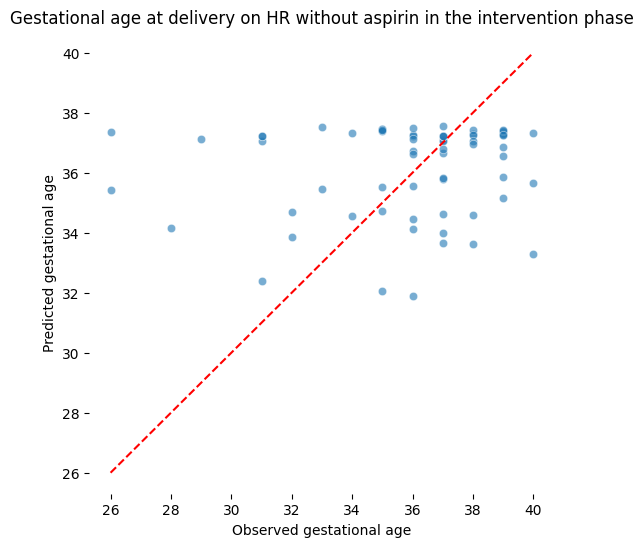

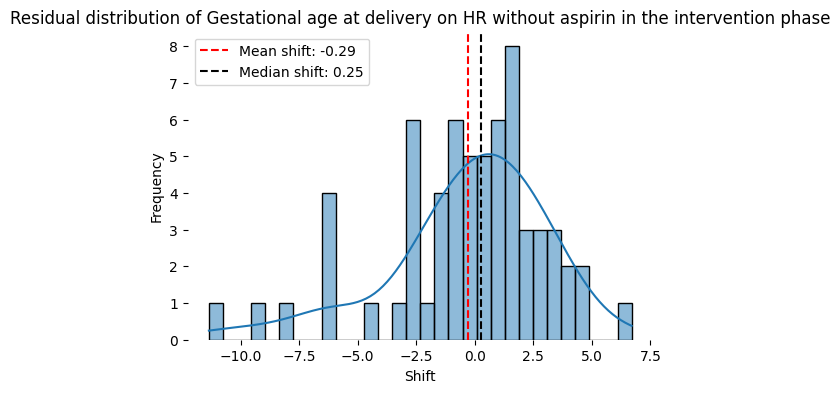

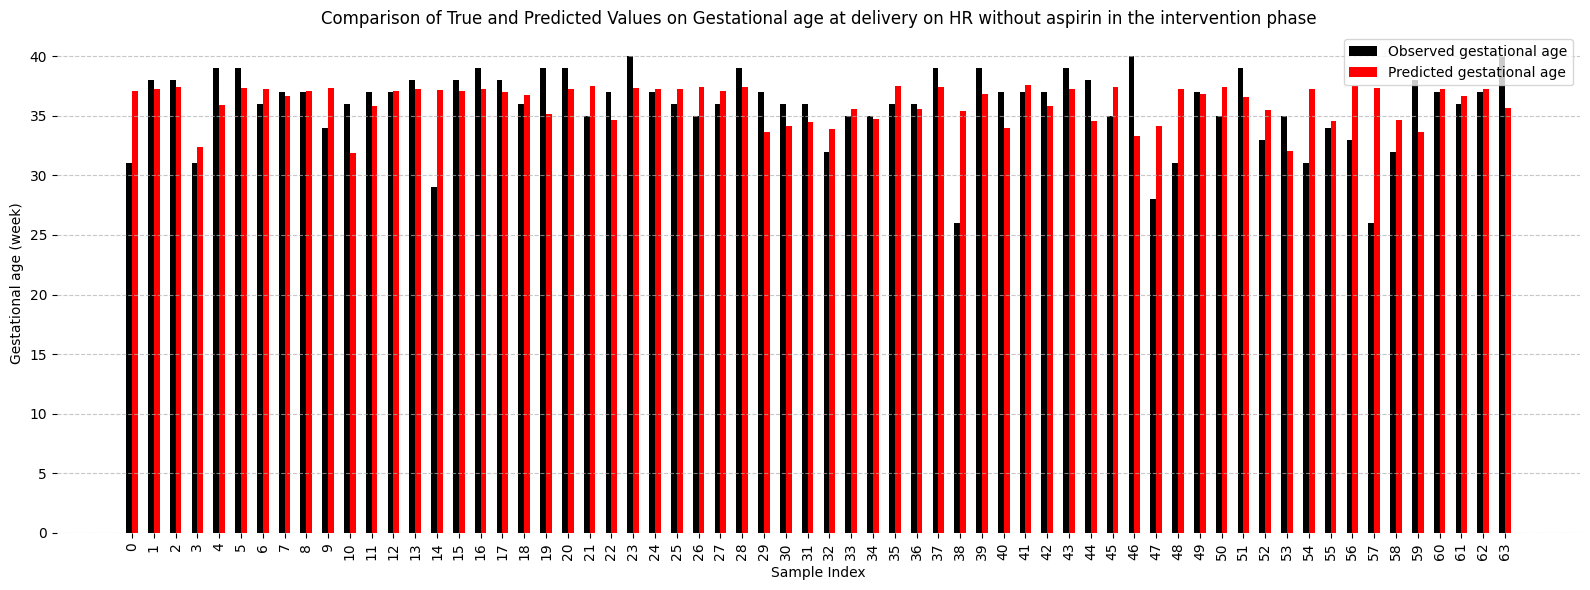

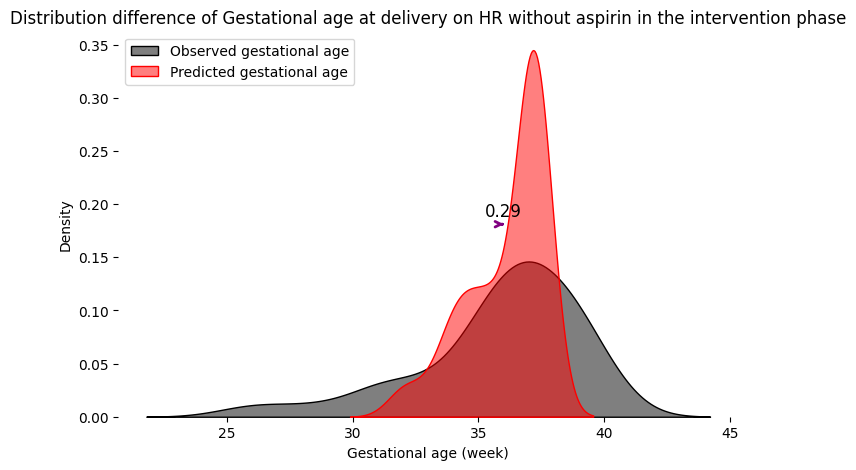

Number of samples in < 37 weeks: 31
___________________________
Means and confidence intervals on subset:
True Mean: 33.42
True 95% CI: 32.32 - 34.52
Pred Mean: 35.87
Pred 95% CI: 35.22 - 36.51
Metrics:
Mean error: -2.4476856082707656
Mean absolute error: 3.1698184042545545
Mean squared error: 17.718316141550694
___________________________
Statistics:
T-test: t-statistic = -3.9149, p-value = 0.0005
95% Confidence Interval: (np.float64(-3.7245633515648224), np.float64(-1.1708078649767089))
___________________________


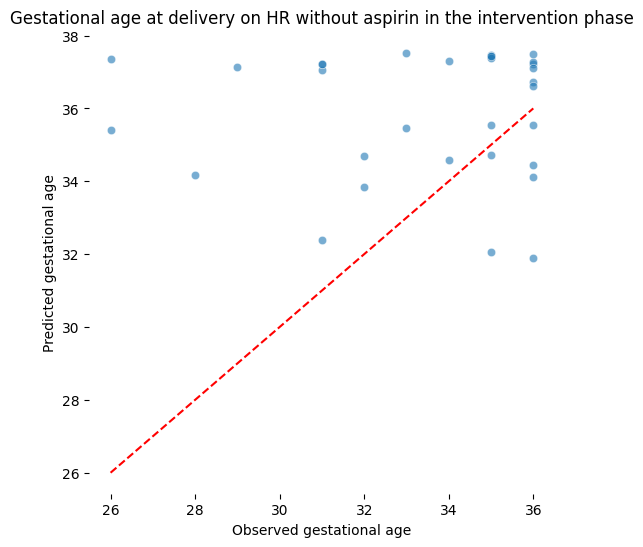

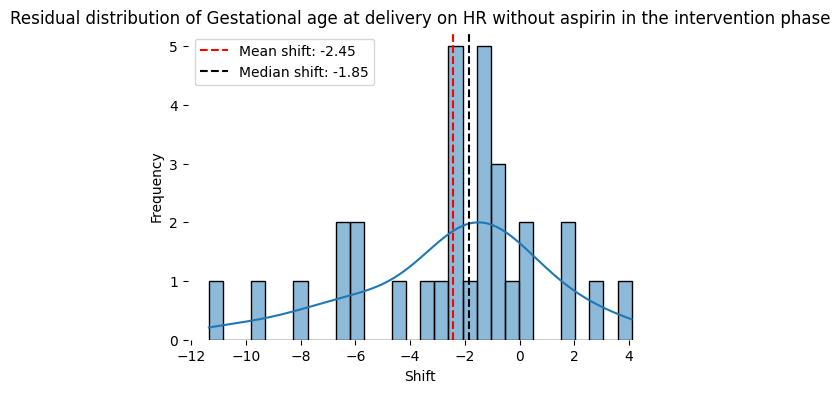

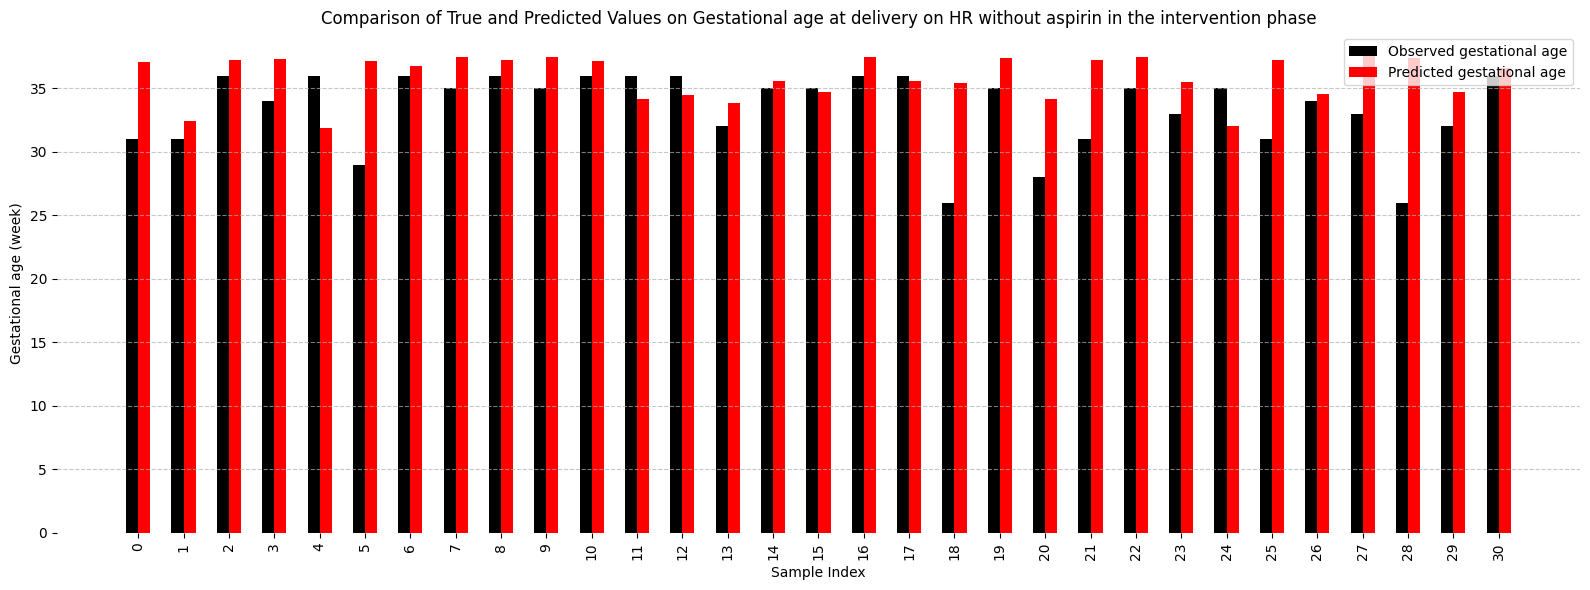

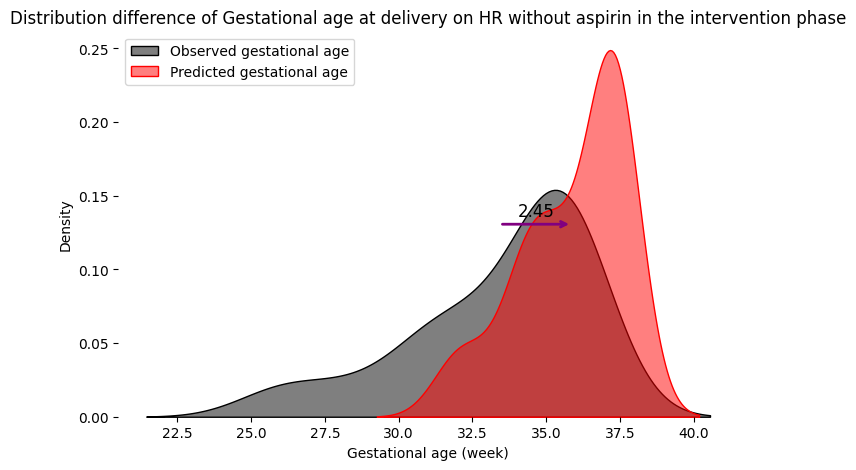

___________________________ 
 

STUDYPHASE CODE, GAWEEK


,target,group,AdjOdds_PE_LT37_Centre,MAge_EDD,HEIGHT,WEIGHT,ETHNICITY_code,FAMHXPE,SMOKER,CONCEPTION_code,Prev_Preg_code,Preg_Interval,CHRONIC_HT,MAP_MOM_CENTRE,UTAPI_MOM_Centre,PLGF_MOM_Centre,SLE/APS,DMTYPE1,DMTYPE2
0,36,2,7,28.2518,159.0,60.0,1,0,0,1,1,NaN,0,1.1650,1.1135,0.2163,0,0,0
1,33,2,45,26.9185,150.0,48.5,1,0,0,1,1,NaN,1,1.2844,1.0061,3.1460,0,0,0
2,36,2,2,27.5098,155.0,50.0,1,0,0,1,1,NaN,1,1.3369,0.9543,0.4072,0,0,0
3,35,2,127,31.9424,157.0,54.0,1,0,0,1,2,6.92,0,0.9049,1.3930,0.1188,0,0,0
4,36,2,24,25.0814,156.0,41.0,1,0,0,1,1,NaN,0,1.2384,0.9861,0.4393,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851,38,3,5,31.2389,156.0,88.0,1,0,0,1,1,NaN,1,1.1765,1.6995,1.0392,0,0,0
852,37,3,50,32.9637,158.0,71.0,1,0,0,3,1,NaN,0,1.1313,1.1157,0.9588,0,0,0
853,36,3,26,35.4825,140.0,50.0,1,0,0,1,2,5.23,1,1.1454,0.7024,1.4084,0,0,0
854,37,3,56,40.2162,159.0,87.0,1,0,0,1,1,NaN,0,1.0623,1.3515,1.0526,0,0,0


Best hyperparameters: {'regressor__max_depth': 3, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 100}
Model Evaluation:
Mean error: 0.005089890249174336
Mean absolute error: 1.710005783304446
Mean squared error: 5.7434566690997375
R2: 0.16957025281338722
___________________________
Means and confidence intervals on whole set:
True Mean: 36.79
True 95% CI: 36.44 - 37.14
Pred Mean: 36.74
Pred 95% CI: 36.58 - 36.90
Metrics:
Mean error: 0.05239785313251542
Mean absolute error: 1.8563541424155583
Mean squared error: 5.902577009974708
___________________________
Statistics:
T-test: t-statistic = 0.3356, p-value = 0.7375
95% Confidence Interval: (np.float64(-0.25516762671729404), np.float64(0.3599633329823249))
___________________________


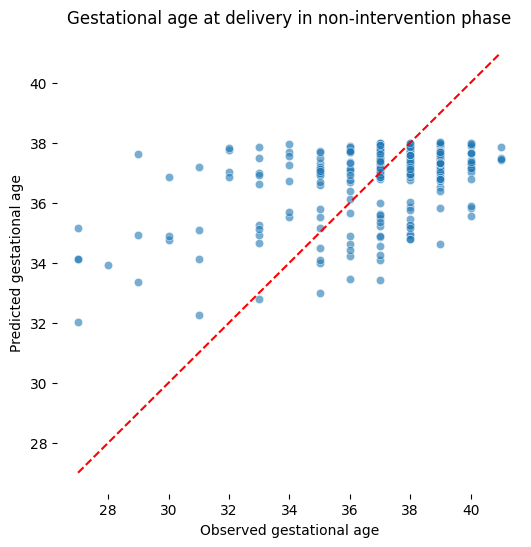

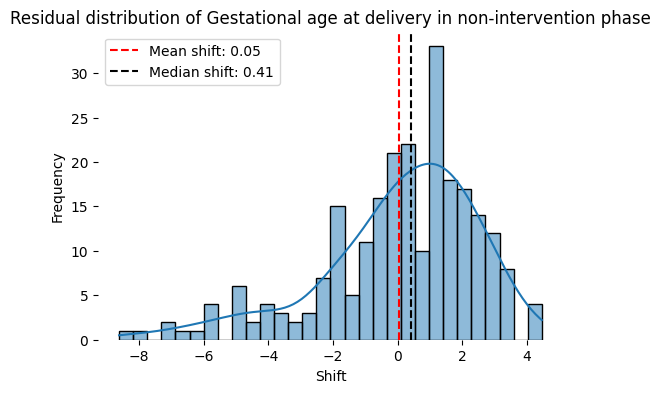

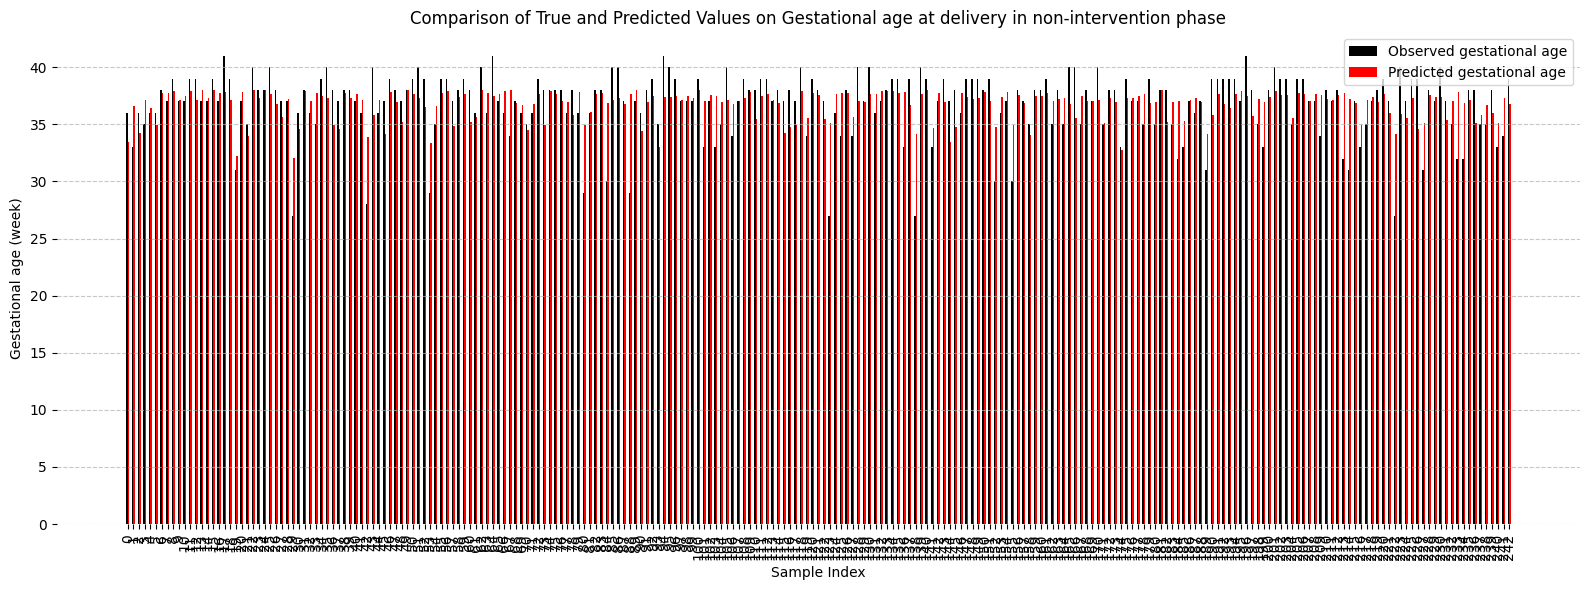

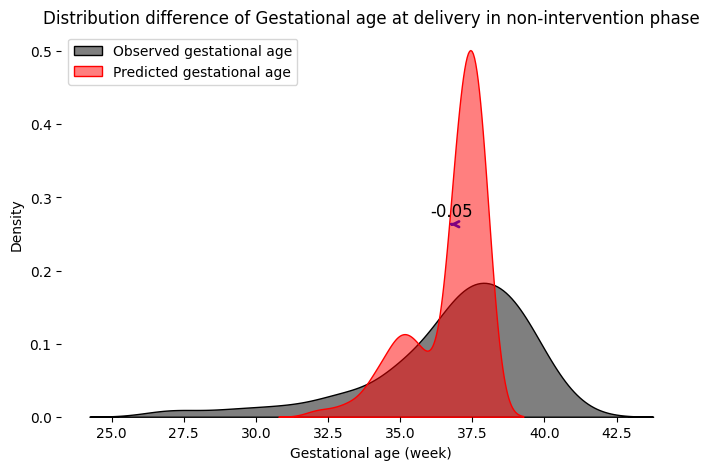

Number of samples in < 37 weeks: 79
___________________________
Means and confidence intervals on subset:
True Mean: 33.67
True 95% CI: 33.09 - 34.25
Pred Mean: 36.09
Pred 95% CI: 35.75 - 36.44
Metrics:
Mean error: -2.423642335409832
Mean absolute error: 2.763590857376207
Mean squared error: 11.608979558899092
___________________________
Statistics:
T-test: t-statistic = -8.9382, p-value = 0.0000
95% Confidence Interval: (np.float64(-2.963469753907733), np.float64(-1.883814916911931))
___________________________


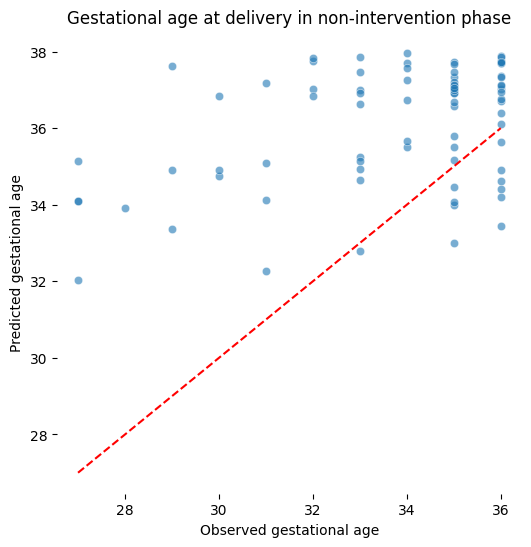

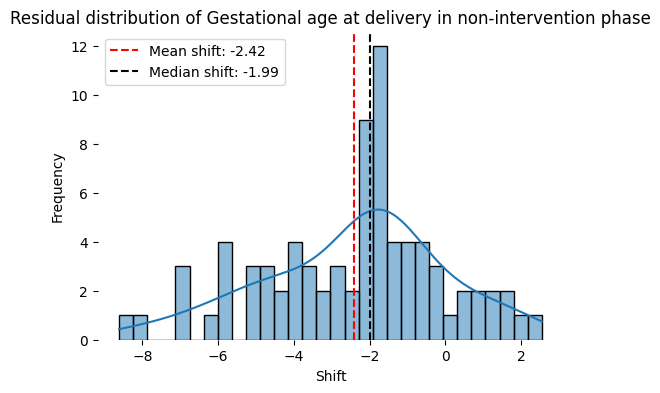

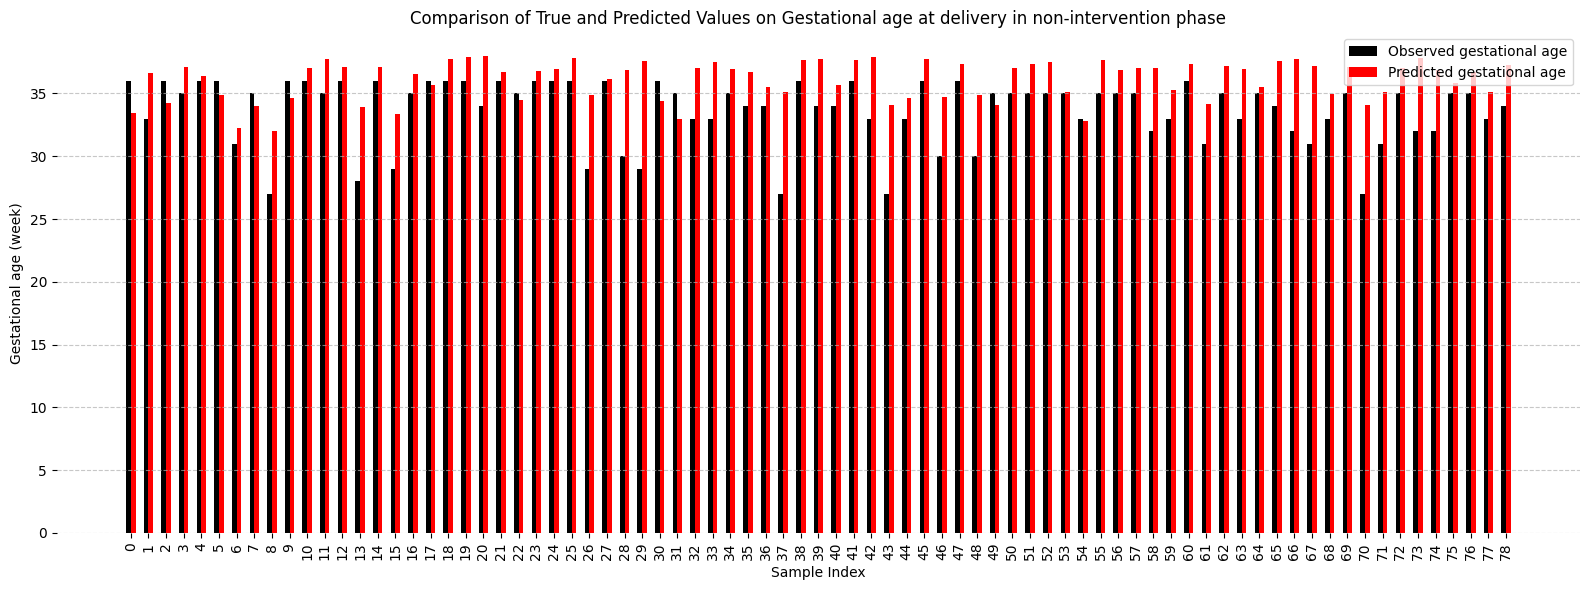

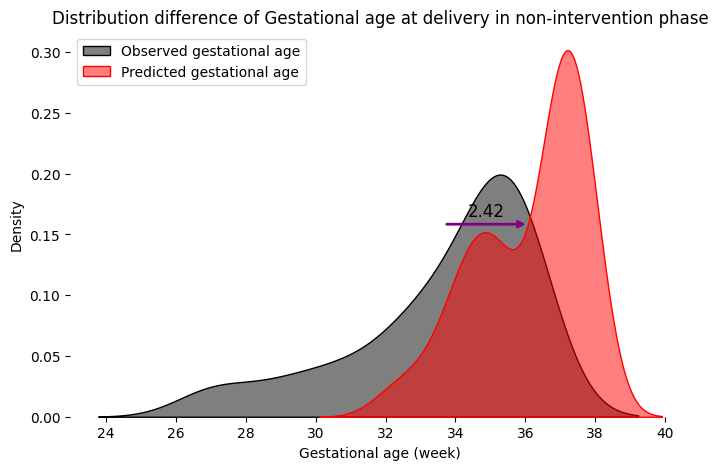

___________________________ 
 

INTERVENTION CODE, ONSET PE WEEK


,target,group,AdjOdds_PE_LT37_Centre,MAge_EDD,HEIGHT,WEIGHT,ETHNICITY_code,FAMHXPE,SMOKER,CONCEPTION_code,Prev_Preg_code,Preg_Interval,CHRONIC_HT,MAP_MOM_CENTRE,UTAPI_MOM_Centre,PLGF_MOM_Centre,SLE/APS,DMTYPE1,DMTYPE2
52,37.0,0.0,24,35.9042,156.0,100.0,1,0,0,1,2,6.04,0,1.1829,1.4695,0.9438,0,0,0
53,35.0,1.0,42,30.6173,162.0,74.0,1,0,0,1,2,1.74,0,1.3643,1.3888,0.7335,0,0,0
58,38.0,1.0,33,29.9932,159.0,76.0,1,0,0,1,1,NaN,0,1.1678,1.3035,0.7973,0,0,0
59,37.0,1.0,48,29.2566,155.0,58.0,1,0,0,3,1,NaN,0,1.4569,0.7580,1.0361,0,0,0
60,37.0,1.0,47,33.8890,161.0,95.0,2,0,0,1,1,NaN,0,1.0362,1.2540,0.8648,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843,31.0,0.0,45,31.4415,159.5,48.0,1,0,0,1,1,NaN,0,1.0819,0.9210,0.3380,0,0,0
846,34.0,1.0,18,27.2169,153.0,53.0,1,0,0,1,1,NaN,1,1.1294,0.7480,0.9730,0,0,0
847,37.0,1.0,26,34.3134,160.0,73.0,1,0,0,1,3,1.49,0,1.0305,0.6760,0.3650,0,0,0
853,30.0,0.0,26,35.4825,140.0,50.0,1,0,0,1,2,5.23,1,1.1454,0.7024,1.4084,0,0,0


Best hyperparameters: {'regressor__max_depth': 3, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 100}
Model Evaluation:
Mean error: -0.016983069797313278
Mean absolute error: 2.236764385331921
Mean squared error: 8.930671635275361
R2: 0.16146051526491279
___________________________
Means and confidence intervals on whole set:
True Mean: 35.67
True 95% CI: 34.65 - 36.70
Pred Mean: 35.41
Pred 95% CI: 34.93 - 35.90
Metrics:
Mean error: 0.25896708774498084
Mean absolute error: 2.729453497863509
Mean squared error: 12.960817915763391
___________________________
Statistics:
T-test: t-statistic = 0.4838, p-value = 0.6309
95% Confidence Interval: (np.float64(-0.8191481709625084), np.float64(1.33708234645247))
___________________________


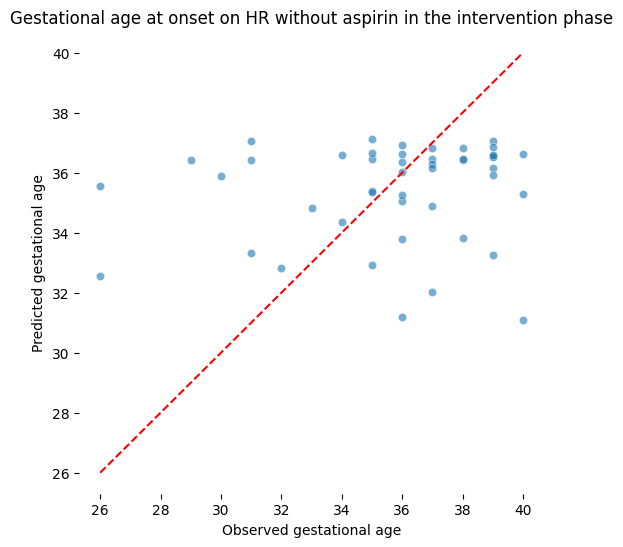

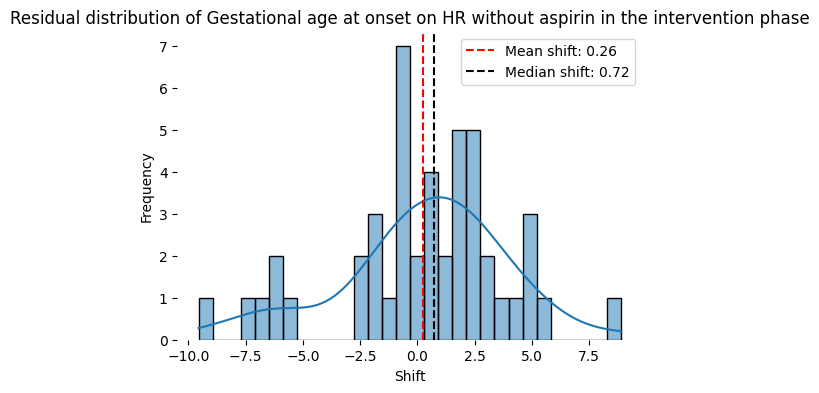

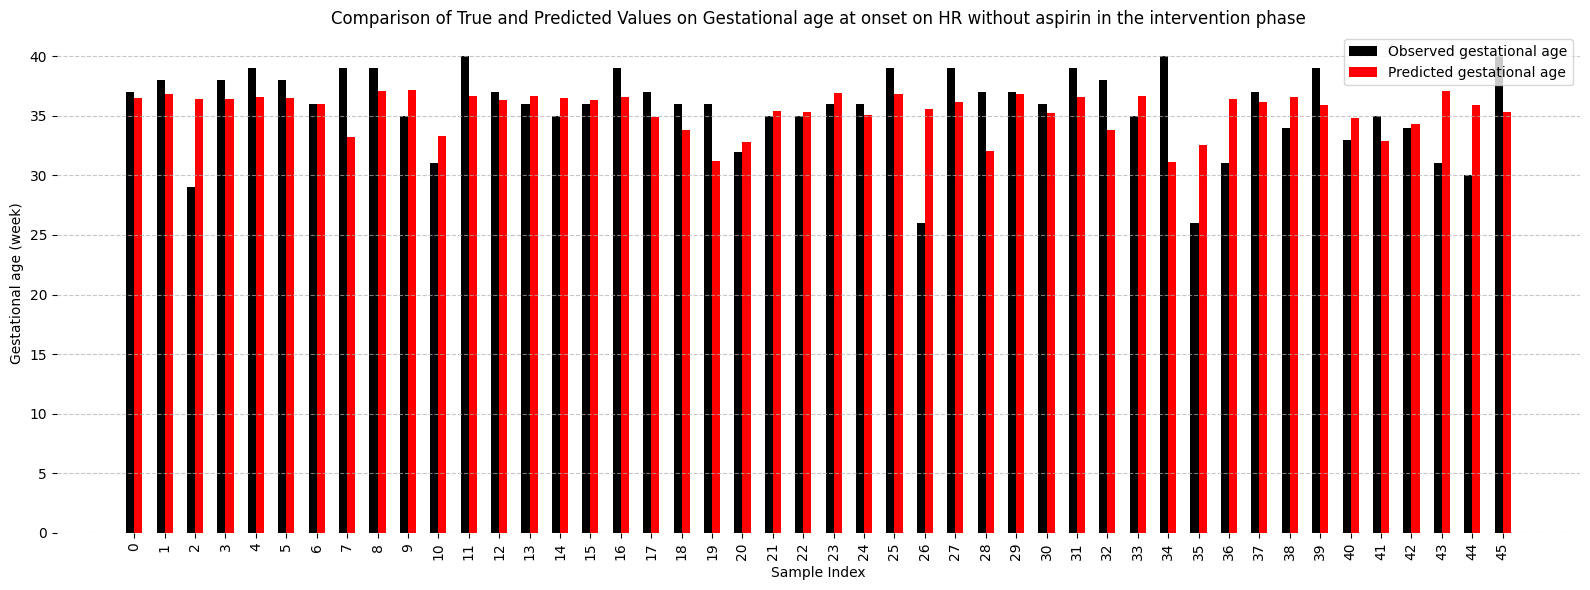

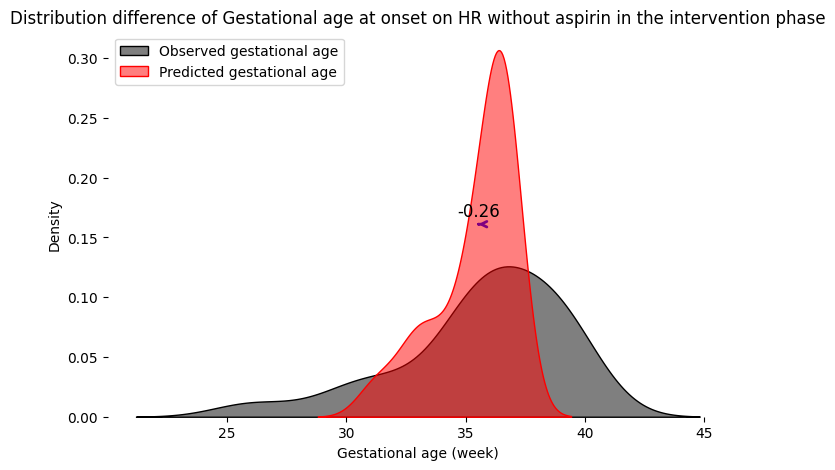

Number of samples in < 37 weeks: 25
___________________________
Means and confidence intervals on subset:
True Mean: 33.40
True 95% CI: 32.12 - 34.68
Pred Mean: 35.24
Pred 95% CI: 34.57 - 35.92
Metrics:
Mean error: -1.8423826820346594
Mean absolute error: 2.7033123125834324
Mean squared error: 14.069886195520702
___________________________
Statistics:
T-test: t-statistic = -2.7624, p-value = 0.0108
95% Confidence Interval: (np.float64(-3.21888545021036), np.float64(-0.46587991385895866))
___________________________


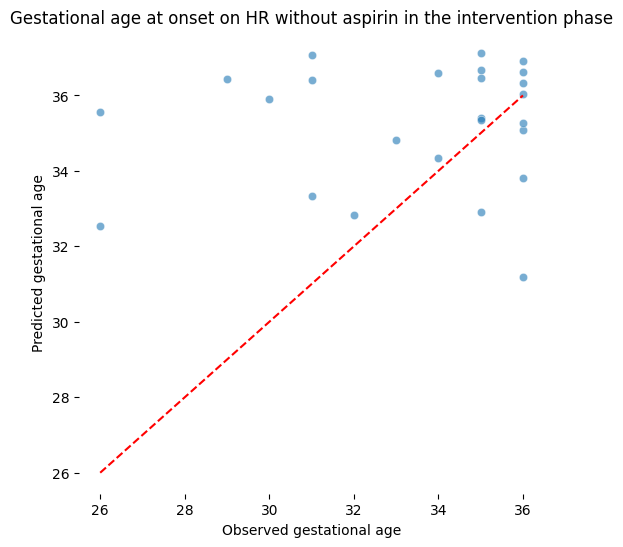

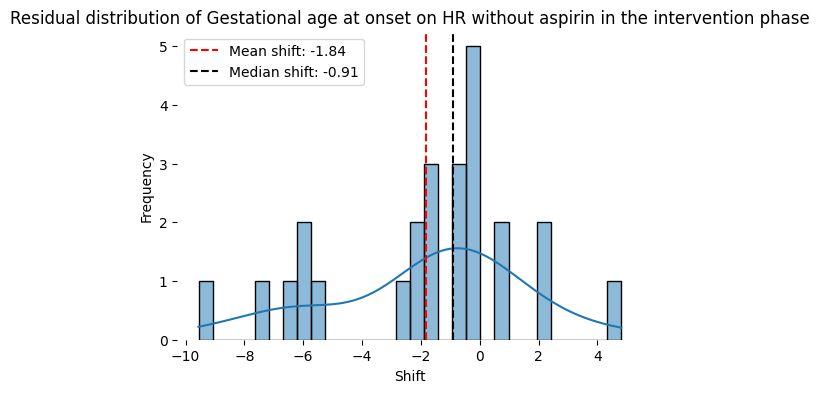

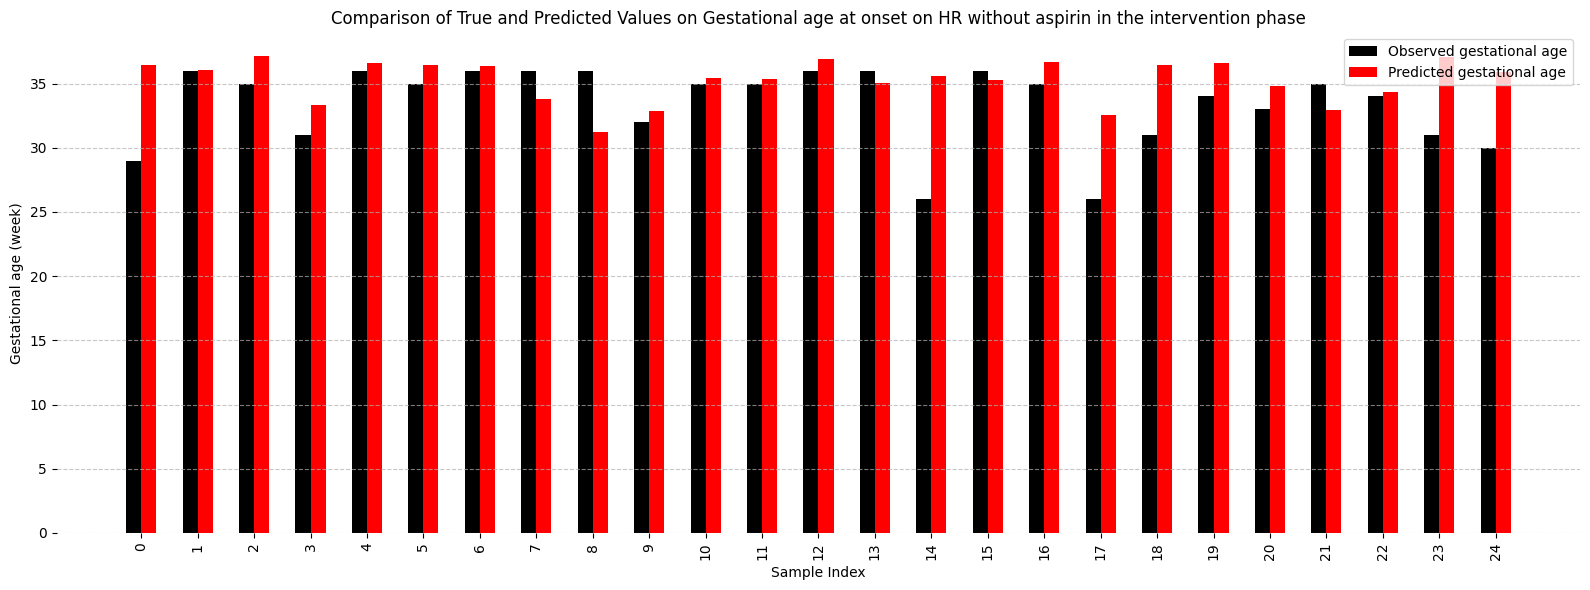

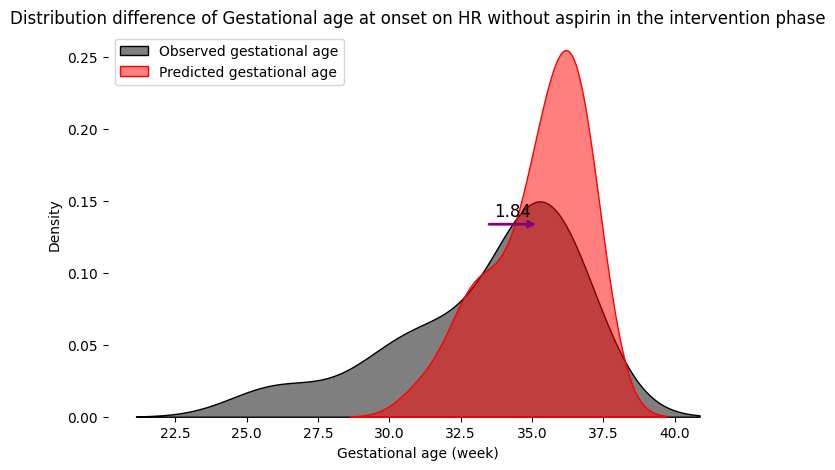

In [ ]:
for c in configurations:

    print(separator, '\n', '\n')
    print(c['title'])

    df = c['df'][columns_of_interest]
    groups = c['groups']
    results_dir = c['results_dir']
    plot_title = c['plot_title']

    display(df)


    # Prepare train and test datasets
    X = df[df['group'] == groups[0]][columns_of_interest]
    test_group = df[df['group'] == groups[1]][columns_of_interest]
    test_group.drop(['group'], axis=1, inplace=True)
    y = X['target']
    X.drop(['target', 'group'], axis=1, inplace=True)

    # Run Grid Search for best hyperparameters
    scores, best_params = get_best_params_reg(model, params, X, y)

    print(f'Best hyperparameters: {best_params}')
    print('Model Evaluation:')
    print_scores(scores)
    print(separator)

    # Fit model with best params on whole dataset
    model.set_params(**best_params)
    model.fit(X, y)

    # Test on other group
    X_test_group = test_group.drop(['target'], axis=1)
    y_test_group = test_group['target']
    y_pred_test_group = model.predict(X_test_group)

    # print means and confidence intervals on whole set
    print('Means and confidence intervals on whole set:')
    compute_mean_and_confidence_interval(y_test_group, y_pred_test_group)

    calculate_shift(y_test_group, y_pred_test_group, results_dir, title='entire', plot_title=plot_title)

    # Test only on subset where target (weeks) < 37
    test_group_subset = test_group[test_group['target'] < 37]
    print(f'Number of samples in < 37 weeks: {test_group_subset.shape[0]}')
    print(separator)

    X_test_group_subset = test_group_subset.drop(['target'], axis=1)
    y_test_group_subset = test_group_subset['target']
    y_pred_subset = model.predict(X_test_group_subset)

    # print means and confidence intervals on subset
    print('Means and confidence intervals on subset:')
    compute_mean_and_confidence_interval(y_test_group_subset, y_pred_subset)

    calculate_shift(y_test_group_subset, y_pred_subset, results_dir, title='subset', plot_title=plot_title)